# Using feature selection to build an efficient potential

In the previous examples (`MLIP_example` and `zundel_i-PI`) we have seen how to use the tools provided by `librascal` in order to build a working potential.  We have already used a "sparsification" technique to select a basis set of environments for the fit, as well as to keep the computational cost of both fitting and evaluating the potential manageable.

Now we will introduce a technique to further optimize the computational cost of the model, and it consists of applying the same sparsification technique along the _features_ (columns) of the feature matrix, in addition to the _samples_ (rows).  This technique was introduced in Ref. [1] and has since been used in numerous applications. Feature selection and sparse feature computation are both available directly in librascal, and this example aims to show the user how to apply them in a realistic setting.

A detail on the selection algorithm itself: `librascal` uses the FPS and CUR algorithms implemented in [`scikit-cosmo`](https://scikit-cosmo.readthedocs.io/en/latest/selection.html).  You will therefore need to have `scikit-cosmo` installed (`pip install skcosmo`) to run this notebook.  Note also that further selection algorithms, notably PCovCUR and PCovFPS, are implemented in `skcosmo` but not yet included directly in `librascal`.

[1]: G. Imbalzano, A. Anelli, D. Giofré, S. Klees, J. Behler, and M. Ceriotti, Automatic Selection of Atomic Fingerprints and Reference Configurations for Machine-Learning Potentials, J. Chem. Phys. 148, 241730 (2018). [doi:10.1063/1.5024611](https://aip.scitation.org/doi/full/10.1063/1.5024611)

----

Let us begin with the Zundel cation example introduced in the previous notebook:

## Initialization

In [1]:
%matplotlib inline
from matplotlib import pylab as plt

import ase
from ase.io import read, write
from ase.build import make_supercell
from ase.visualize import view
import numpy as np
# If installed -- not essential, though
try:
    from tqdm.notebook import tqdm
except ImportError:
    tqdm = (lambda i, **kwargs: i)

from time import time
# Print some extra information during the selection process
import logging
logging.basicConfig(level=logging.INFO)

from librascal.models import Kernel, train_gap_model, compute_KNM
from librascal.representations import SphericalInvariants
from librascal.utils import from_dict, to_dict, CURFilter, FPSFilter, dump_obj, load_obj

In [2]:
cd i-PI/zundel/

/Users/Max/Work/codes/librascal/examples/i-PI/zundel


In [3]:
# Load the first N structures of the zundel dataset
N_dataset = 1000
frames = read('zundel_dataset.xyz', index=':{}'.format(N_dataset))
energies = np.loadtxt('zundel_energies.txt')[:N_dataset]
forces = np.concatenate([frame.arrays['forces'] for frame in frames])

In [4]:
forces.shape

(7000, 3)

In [5]:
# Number of structures to train the model with
n_train = 800

global_species = [1, 8]

# Select randomly n structures for training the model
ids = list(range(N_dataset))
np.random.seed(10)
np.random.shuffle(ids)

train_ids = ids[:n_train]
frames_train = [frames[ii] for ii in ids[:n_train]]
e_train = np.array([energies[ii] for ii in ids[:n_train]])
f_train = np.concatenate([frame.arrays['forces'] for frame in frames_train])
# Test on the remaining 200 molecules
test_ids = [int(i) for i in ids[n_train:]] 
frames_test = [frames[ii] for ii in test_ids]
e_test = np.array([energies[ii] for ii in test_ids])
f_test = np.concatenate([frame.arrays['forces'] for frame in frames_test])

## Set hyperparameters

In [6]:
# Atomic energy baseline - assuming all configurations have the same number of atoms
atom_energy_baseline = np.mean(energies)/len(frames[0])
energy_baseline = {int(species): atom_energy_baseline for species in global_species}

In [7]:
# define the parameters of the spherical expansion
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=3.0, 
              max_radial=8, 
              max_angular=6, 
              gaussian_sigma_constant=0.5,
              gaussian_sigma_type="Constant",
              cutoff_function_type="RadialScaling",
              cutoff_smooth_width=0.5,
              cutoff_function_parameters=
                    dict(
                            rate=1,
                            scale=3.5,
                            exponent=4
                        ),
              radial_basis="GTO",
              normalize=True,
              optimization=
                    dict(
                            Spline=dict(
                               accuracy=1.0e-05
                            )
                        ),
              compute_gradients=False
              )


soap = SphericalInvariants(**hypers)

## Compute descriptors

In [8]:
managers = []
for f in frames_train:
    f.wrap(eps=1e-18)

start = time()
managers = soap.transform(tqdm(frames_train))
print ("Execution: ", time()-start, "s")

Execution:  0.30106329917907715 s


## Sample selection

Now we select the set of sparse _samples_ (environments).  In effect, we are selecting an optimally diverse set of _rows_ of the feature matrix $X$.

In [9]:
# select the sparse points for the sparse kernel method with FPS on the whole training set
n_sparse_env = {1:50, 8:100}
sample_compressor = FPSFilter(soap, n_sparse_env, act_on='sample per species')
X_sparse = sample_compressor.select_and_filter(managers)

INFO:rascal.utils.filter:The number of pseudo points selected by central atom species is: {1: 50, 8: 100}
INFO:rascal.utils.filter:Selecting species: 1
INFO:rascal.utils.filter:Selecting species: 8


## Model assessment: Sparse samples only

Let's build our potential and get some benchmarks.

In [10]:
zeta = 2

start = time()
hypers['compute_gradients'] = True
soap_grads = SphericalInvariants(**hypers)
kernel = Kernel(soap_grads, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse')

KNM = compute_KNM(tqdm(frames_train, leave=True, desc="Computing kernel matrix"), X_sparse, kernel, soap_grads)

model = train_gap_model(kernel, frames_train, KNM, X_sparse, e_train, energy_baseline, 
                        grad_train=-f_train, lambdas=[1e-12, 1e-12], jitter=1e-13)

# save the model to a file in json format for future use
dump_obj('zundel_model.json', model)
np.savetxt('Structure_indices.txt', ids)
print ("Execution: ", time()-start, "s")

Execution:  4.386488199234009 s


In [11]:
# make predictions on the test set
e_pred = []
f_pred = []
for f in tqdm(frames_test):
    positions = f.get_positions()
    f.wrap(eps=1e-18)
    m = soap_grads.transform(f)
    e_pred.append(model.predict(m)[0])
    f_pred.append(model.predict_forces(m))

e_pred = np.array(e_pred)
f_pred = np.concatenate(f_pred)

In [12]:
from librascal.utils import get_score

score = get_score(e_pred, e_test)
RMSE = score['RMSE']
sigma_test = np.std(e_test)
print("RMSE = ", RMSE*1000.0, "meV")
print("Test set stdev = ", sigma_test, " eV")
print("Relative RMSE = ", RMSE/sigma_test*100.0, " %")

RMSE =  37.27416992356848 meV
Test set stdev =  0.274800153468654  eV
Relative RMSE =  13.564100839492538  %


## Now introduce feature selection

This potential uses quite a large number of features to make its predictions:

In [13]:
soap.get_num_coefficients(n_species=2)

1344

Since the cost to compute the kernel (and hence evaluate the model) scales asymptotically linearly with the number of features [2], it would be nice if we could get away with using fewer components of the feature vector.

[2]: F. Musil, M. Veit, A. Goscinski, G. Fraux, M. J. Willatt, M. Stricker, T. Junge, and M. Ceriotti, Efficient Implementation of Atom-Density Representations, J. Chem. Phys. 154, 114109 (2021). [doi:10.1063/5.0044689](https://aip.scitation.org/doi/10.1063/5.0044689)

To select features (columns) instead of samples (rows), we use the same selector class as above with a few changes.  Let's start with a conservative estimate of half the total number of features:

In [14]:
# select the features with FPS, again the whole training set
n_sparse_feat = 600
feat_compressor = FPSFilter(soap, n_sparse_feat, act_on='feature')
feat_sparse_parameters = feat_compressor.select_and_filter(managers)

Note that here we use the full feature matrix again, but in real scientific applications this might not be possible or practical due to the size of the full matrix.  In this case we might sub-select samples, either randomly or using our existing sparse sample selection*, to obtain a smaller matrix to work with.

*You might be wondering how we do the sparse sample selection in the first place if the full feature matrix is too big to fit in memory.  There are various ways around this, including iterative or hierarchical selection methods, or we could just do feature selection first on a random subset and then do sample selection on the feature-sparsified matrix.  The best method to use will in general depend on the application and is out of the scope of this tutorial.

In [15]:
feat_sparse_parameters.keys()

dict_keys(['coefficient_subselection', 'selected_feature_ids_global', 'selected_feature_ids_global_selection_ordering'])

The result is a dictionary that tells the `SphericalInvariants` class which coefficents to compute.  In order to use it, we must update the `hypers` and create a new, sparsified version of the `soap` feature calculator.

In [16]:
hypers['coefficient_subselection'] = feat_sparse_parameters['coefficient_subselection']
soap_fsparse = SphericalInvariants(**hypers)

In [17]:
start = time()
managers_sparsefeat = soap_fsparse.transform(tqdm(frames_train))
print("Execution time: {} s".format(time() - start))

Execution time: 1.7077140808105469 s


In [18]:
# Bit of a hack because we can't directly use the old `sample_compressor` on the new features
sample_compressor_sparse = FPSFilter(soap_fsparse, n_sparse_env, act_on='sample per species')
sample_compressor_sparse.selected_sample_ids_by_sp = sample_compressor.selected_sample_ids_by_sp
X_sparse_sparsefeat = sample_compressor_sparse.filter(managers_sparsefeat)

### How do we know how many features to select?

With FPS, one metric we can look at to get a rough estimate of the required number of features is the Hausdorff distance of each selected point (basically, the distance of the selected point to the closest point in the "blob" of already-selected points).  This tells us how far (in feature space) each selected point is from the selected set, and _very_ roughly, the amount of diversity it adds to the set.  So when the decrease in this distance starts to slow down, it indicates that we are getting less of an information return for each point added to the set.

Text(0.5, 1.0, 'FPS selection on features')

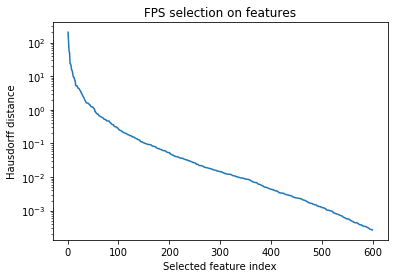

In [19]:
fps_dists = feat_compressor.get_fps_distances()
plt.semilogy(fps_dists)
plt.xlabel('Selected feature index')
plt.ylabel('Hausdorff distance')
plt.title('FPS selection on features')

From this plot, it seems that we might even be able to get away with 200 or 300 features, but we should test this more rigorously.  What we really care about is how well these sparsified features reproduce the _kernel_ -- so let's look at the difference in the kernel between the sparse _environments_, with and without _feature_ sparsification.

In [20]:
K_MM_fullfeat = kernel(X_sparse)
kernel_sparsefeat = Kernel(soap_fsparse, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse')
K_MM_sparsefeat = kernel_sparsefeat(X_sparse_sparsefeat)

In [21]:
np.linalg.norm(K_MM_fullfeat - K_MM_sparsefeat, 'fro')

0.7171404793446092

In [22]:
np.linalg.norm(K_MM_fullfeat, 'fro')

104.82383972597799

So the difference in the norms is less than 1% of the norm of the kernel matrix.  Let's see if we can use an even smaller number of features:

In [23]:
def get_feature_sparsified_soap(Nselect, full_soap, managers, sample_compressor):
    feat_compressor = FPSFilter(full_soap, Nselect, act_on='feature')
    feat_sparse_parameters = feat_compressor.select_and_filter(managers)
    soap_hypers = full_soap._get_init_params()
    soap_hypers['coefficient_subselection'] = feat_sparse_parameters['coefficient_subselection']
    soap_fsparse = SphericalInvariants(**soap_hypers)
    managers_sparsefeat = soap_fsparse.transform(managers)
    sample_compressor_sparse = FPSFilter(soap_fsparse, n_sparse_env, act_on='sample per species')
    sample_compressor_sparse.selected_sample_ids_by_sp = sample_compressor.selected_sample_ids_by_sp
    X_sparse_sparsefeat = sample_compressor_sparse.filter(managers_sparsefeat)
    return soap_fsparse, managers_sparsefeat, X_sparse_sparsefeat

In [24]:
soap_smallsparse, managers_sparsefeat, X_sparse_sparsefeat = get_feature_sparsified_soap(
    200, soap, managers, sample_compressor
)

In [25]:
kernel_sparsefeat = Kernel(soap_smallsparse, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse')
K_MM_sparsefeat = kernel_sparsefeat(X_sparse_sparsefeat)

In [26]:
np.linalg.norm(K_MM_fullfeat - K_MM_sparsefeat, 'fro')

0.8514895312542564

Barely a difference. So let's proceed with 200 features and see how accurate our model is:

## Model assessment: Sparse samples and sparse features

In [27]:
zeta = 2

start = time()
sparse_hypers = soap_smallsparse._get_init_params()
sparse_hypers['compute_gradients'] = True
soap_fsparse_grads = SphericalInvariants(**sparse_hypers)
kernel_fsparse = Kernel(soap_fsparse_grads, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse')

KNM = compute_KNM(tqdm(frames_train, leave=True, desc="Computing kernel matrix"), X_sparse_sparsefeat, kernel_fsparse, soap_fsparse_grads)

model_fsparse = train_gap_model(
    kernel_fsparse,
    frames_train,
    KNM,
    X_sparse_sparsefeat,
    e_train,
    energy_baseline,
    grad_train=-f_train,
    lambdas=[1e-12, 1e-12],
    jitter=1e-13
)

# save the model to a file in json format for future use
dump_obj('zundel_model_featsparse.json', model)
np.savetxt('Structure_indices.txt', ids)
print ("Execution: ", time()-start, "s")

Execution:  1.8869318962097168 s


In [28]:
# make predictions on the test set
e_pred = []
f_pred = []
for f in tqdm(frames_test):
    positions = f.get_positions()
    f.wrap(eps=1e-18)
    m = soap_fsparse_grads.transform(f)
    e_pred.append(model_fsparse.predict(m))
    f_pred.append(model_fsparse.predict_forces(m))

e_pred = np.array(e_pred)
f_pred = np.concatenate(f_pred)

Notice how it is already much faster to train and evaluate a model.  Now, how accurate is it?

In [29]:
from librascal.utils import get_score

score = get_score(e_pred.flat, e_test)
RMSE = score['RMSE']
sigma_test = np.std(e_test)
print("RMSE = ", RMSE*1000.0, "meV")
print("Test set stdev = ", sigma_test, " eV")
print("Relative RMSE = ", RMSE/sigma_test*100.0, " %")

RMSE =  26.000018450459176 meV
Test set stdev =  0.274800153468654  eV
Relative RMSE =  9.461427922173616  %


In fact, it's slightly _more_ accurate than the model built with the full feature set.  This might be because the model built with the full features overfits slightly, since it has more than enough features to describe the dataset.  If we were to optimize the regularizers for both these fits, it is likely that the feature-sparsified model would have approximately equal or lower accuracy than the full model.

## Timings

Now, back to our main motivation for doing feature sparsification.  If we use these models to run molecular dynamics (MD), how much of a speedup do we get with the feature-sparsified model?

In [30]:
from ase.md import MDLogger
from ase.md.langevin import Langevin
from ase import units
from ase.io.trajectory import Trajectory
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution

In [31]:
from librascal.models.asemd import ASEMLCalculator

Let's use the ASE calculator (as in `MLIP_example.ipynb`), which we can run directly in the notebook.

Full model:

In [32]:
atoms = frames_test[0].copy()
calc = ASEMLCalculator(model, soap_grads)
T = 200

start = time()

MaxwellBoltzmannDistribution(atoms, T * units.kB)
atoms.set_calculator(calc)
dyn = Langevin(atoms, 0.5 * units.fs, units.kB * T, 0.002)
dyn.run(500)

elapsed = time() - start
print("Elapsed time: {} s ({} ms per timestep)".format(elapsed, elapsed / 500 * 1000))

Elapsed time: 2.3851280212402344 s (4.770256042480469 ms per timestep)


Feature-sparsified model:

In [33]:
atoms = frames_test[0].copy()
calc = ASEMLCalculator(model_fsparse, soap_fsparse_grads)
T = 200

start = time()

MaxwellBoltzmannDistribution(atoms, T * units.kB)
atoms.set_calculator(calc)
dyn = Langevin(atoms, 0.5 * units.fs, units.kB * T, 0.002)
dyn.run(500)

elapsed = time() - start
print("Elapsed time: {} s ({} ms per timestep)".format(elapsed, elapsed / 500 * 1000))

Elapsed time: 1.2145779132843018 s (2.4291558265686035 ms per timestep)


So our feature-sparsified model is about twice as fast as the full model, and with the same accuracy!

(But since we selected about one-sixth of the features, why isn't it 6x as fast? Well, there are various overheads, especially in the computation of gradients that are needed for MD forces, that keep the computational cost from scaling exactly linearly with the feature vector size.  We could probably push the cost down even further by optimizing the feature size more aggressively, but if we want to keep the same accuracy we probably won't be able to get a speedup above about 3x.  Note also that the impact of this optimization is much more pronounced for models with much larger feature sizes -- e.g. many atomic species or high `max_radial`/`max_angular` parameters.)